In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Máquinas Cuánticas de Soporte Vectorial.

Las máquinas de soporte vectorial son modelos de entrenamiento supervisado para la clasificación de datos. En este taller construiremos un clasificador clásico y uno cuántico para discriminar una característica de un dataset a elección. 

## Problema 1: Dataset.

Construya datasets $(\vec{x}_{i},y_{i})$ y $(\vec{t}_{i},s_{i})$ para entrenar y testear un clasificador. Por ejemplo, pueden elegir y filtrar un dataset de [kaggle](https://www.kaggle.com/datasets). Estos datasets deben tener una característica bidimensional $\vec{x}_i$ ($\vec{t}_i$) y otra binaria $y_i$ ($s_i$). Además, el tamaño del set de entrenamiento $n_{train}$ debe estar entre 10 y 30, mientras que el de test $n_{test}$ debe ser 10. Haga un gráfico de estos datasets.

In [2]:
data = []
with open('winequalityN.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        data.append(row)

n_datos = len(data) - 1
data[0], n_datos 

(['type',
  'fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 6497)

In [3]:
def select_data_random( N, colums=[2,5] ):
    """
    N : numero de datos para el entrenamiento o el test.
    """
    index_train = np.random.randint(1, n_datos-1, N )
    data_train = [  [ data[k][j] for j in [0]+colums ] for k in index_train  ] 

    X_train = np.zeros( (N, 2) )
    Y_train = np.zeros( N )

    for j in range(N):
        if data_train[j][0] == "red":
            Y_train[j] = 0
        elif data_train[j][0] == "white":
            Y_train[j] = 1
        X_train[j,0] = float( data_train[j][1] )
        X_train[j,1] = float( data_train[j][2] )
    
    return X_train, Y_train


In [4]:
N = 30
M = 10

np.random.seed(30)
X_train, Y_train = select_data_random( N )
X_test, Y_test   = select_data_random( M )

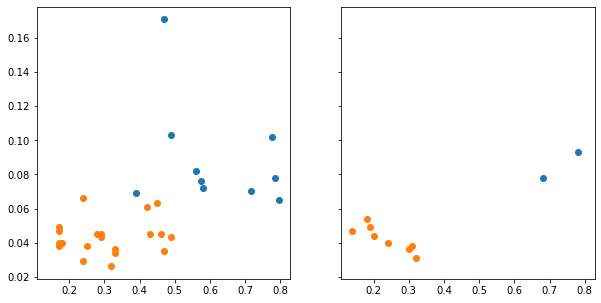

In [5]:
fig, axes = plt.subplots( 1,2 , figsize=( 10, 5 ), sharey = True, sharex = True )
axes[0].scatter( X_train[Y_train==0][:,0], X_train[Y_train==0][:,1] )
axes[0].scatter( X_train[Y_train==1][:,0], X_train[Y_train==1][:,1] )
axes[1].scatter( X_test[Y_test==0][:,0], X_test[Y_test==0][:,1] )
axes[1].scatter( X_test[Y_test==1][:,0], X_test[Y_test==1][:,1] )

## Problema 2: Kernel clásico.

Calcule el siguiente Kernel para sus datos

$$ K_{jk}(\vec{x}) = ( 1 + \vec{x}_j\cdot\vec{x}_k )^2, \qquad j,k = 1,\dots, n_{train} . $$

También calcule la matriz

$$ T_{jk}(\vec{x},\vec{t}) = ( 1 + \vec{t}_j\cdot\vec{x}_k )^2, \qquad j=1,\dots n_{test},\quad k=1,\dots,n_{train}. $$

para realizar el test del entrenamiento. Grafique estos Kernels.

In [6]:
def kernel_clasico( X_train, X_test=None ):

    if X_test is None:
        X_test = X_train

    X_train = np.array(X_train)
    X_test  = np.array(X_test)

    K_train = np.zeros((X_train.shape[0], X_test.shape[0]))
    for i, x_train in enumerate(X_train):
        for j, x_test in enumerate(X_test):
            K_train[i, j] = ( 1 + np.dot(x_train, x_test) )**2 

    return K_train.T

In [7]:
K_train = kernel_clasico( X_train )
K_test  = kernel_clasico( X_train, X_test )

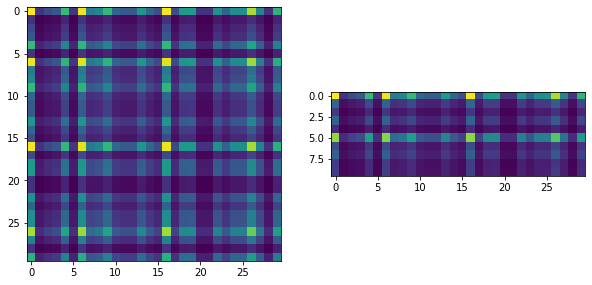

In [8]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
ax[0].imshow( K_train )
ax[1].imshow( K_test )

## Problema 3. Entrenamiento con Kernel clásico.
Entrene un discriminador con el dataset y el kernel clásico que construyó. Posteriormente, realice un test de su entrenamiento.

In [9]:
svm = SVC( kernel = 'precomputed' )
svm.fit( K_train, Y_train )
Y_predict = svm.predict( K_test )
Y_test, Y_predict, svm.score(K_test, Y_test)  

(array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1.]),
 array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1.]),
 1.0)

## Problema 4: Codificación en un estado cuántico.

Cree una función  que tenga como argumento $\vec{x}$ bidimensional y como salida un circuito cuántico paramétrico evaluado en $\vec{x}$ a elección. Denotaremos el estado de este circuito como $|\phi(\vec{x})\rangle$. Como referencia puede utilizar el circuito de la siguiente figura, pero puede modificarlo si lo desea.

<img src=img/figure.png>


In [10]:
from qiskit import QuantumCircuit, Aer, execute

def circuit( x ):

    qc = QuantumCircuit(2, 2)
    qc.h([0,1])
    qc.rz(2*np.pi*x[0], 0)
    qc.rz(2*np.pi*x[1], 1)
    qc.cx(0,1)
    qc.rz(2*np.pi*x[1], 1)
    return qc

In [11]:
from qiskit.circuit import Parameter

theta = Parameter('$\\theta$')
phi = Parameter('$\\phi$')
qc1 = circuit( [ theta, phi ] )

## Problema 5: Kernel Cuántico.

Cree un programa capaz de evaluar el Kernel cuántico de los datos codificados en el estado $|\phi(\vec{x})\rangle$, es decir

$$  K_{jk}^Q =  | \langle \phi(\vec{x}_j) | \phi(\vec{x}_k)\rangle |^2, \qquad j,k = 1,\dots, n_{train}. $$

Esto requiere componer los circuitos de $\langle\phi(\vec{x}_j)|$ y $|\phi(\vec{x}_k)\rangle$, y después realizar una medida. Análogamente, evalue la matriz

$$  T_{jk}^Q =  | \langle \phi(\vec{t}_j) | \phi(\vec{x}_k) \rangle |^2, \qquad j= 1,\dots, n_{test},\quad k = 1,\dots, n_{train}. $$

Grafique ambas matrices.


In [12]:
def circuit_for_kernel_element(x_1, x_2 ):
    
    """ 
    x_1     : vector bidimensional
    x_2     : vector bidimensional
    """

    qc = QuantumCircuit(2, 2)
    qc.compose( circuit( x_1 ), qubits=[0,1], inplace=True )
    qc.compose( circuit( x_2 ).inverse(), qubits=[0,1], inplace=True )
    qc.measure(range(2), range(2))

    return qc

def Quantum_Kernel( X_train, X_test=None, backend=Aer.get_backend('statevector_simulator'), shots=100 ):
    """ 
    X_train : vector bidimensional para entrenar
    X_test  : vector bidimensional para testear
    K_q     : Kernel cuantico
    backend : simulador o computador cuantico
    shots   : numero de shots     
    """

    if X_test is None:
        X_test = X_train
    X_train = np.array(X_train)
    X_test  = np.array(X_test)

    qcs = []
    for x_train in X_train:
        for x_test in X_test:
            qcs.append( circuit_for_kernel_element( x_train, x_test ) )

    job = execute(qcs, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()

    K_q = np.zeros(( X_test.shape[0], X_train.shape[0]))
    k = 0
    for j, x_train in enumerate(X_train):
        for i, x_test in enumerate(X_test):
            K_q[i, j] = counts[k]["00"] / shots if "00" in counts[k] else 0
            k         += 1

    return K_q

In [13]:
Kq_train = Quantum_Kernel( X_train )
Kq_test  = Quantum_Kernel( X_train, X_test )

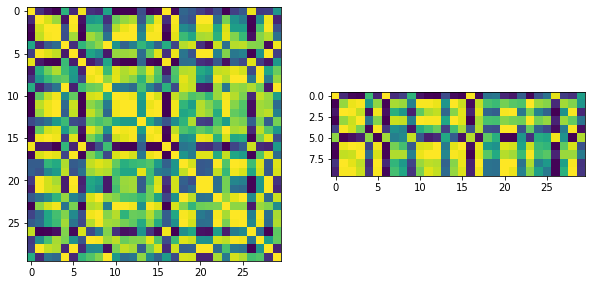

In [14]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
ax[0].imshow( Kq_train )
ax[1].imshow( Kq_test )

## Problema 6. Entrenamiento con Kernel Cuántico.
Entrene un discriminador con el dataset y el kernel cuántico que construyó. Posteriormente, realice un test de su entrenamiento.

In [15]:
svm = SVC( kernel = 'precomputed' )
svm.fit( Kq_train, Y_train )
Y_pred_quantum = svm.predict(Kq_test)
Y_test, Y_pred_quantum, svm.score(Kq_test, Y_test)

(array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1.]),
 array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1.]),
 1.0)